In [1]:
### Notebook for plotting graphics from polygons

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point, Polygon
from shapely.geometry import MultiPolygon
from bs4 import BeautifulSoup




##### Goals for notebook

create polygons, and rotate to the same orientation.

theory: grab the linestring of one of the foul line measurements. should just be first 2 coordinates of either polygon - check the distance to make sure they are viable lines

measure the angle from the line string to a reference, either 180 of 90 d . create a factor to rotate the plot so reference line is 45 degrees areound the home plate point  then plot


In [2]:
#### Load data from kml file exported by Google Earth

file_path = ('data/kml/ballparks.kml')

with open(file_path) as file:

    xml_data = file.read()



# Initialize soup variables for parsing file
soup = BeautifulSoup(xml_data, 'xml')

folders = soup.Document.Folder
list = soup.Document.Folder.find_all('Folder')
# layers = soup.Document.Folder.Folder
# polygons = soup.Document.Folder.Placemark.Polygon

## Create a dataframe to hold the data parsed from xml
df = pd.DataFrame(columns=['field', 'foul', 'fop'])


## Loop through the folders and extract the data
i = 0   

for i in range(len(list)):

    folders = list[i]
    field_name = folders.find('name').text
    foul = folders.find_all('coordinates')[0].text
    fop = folders.find_all('coordinates')[1].text

    row = {
        'field': field_name,
        'foul': foul,
        'fop': fop
    }

    i+=1

    df = df.append(row, ignore_index=True)

## Cleaning
# remove new line and and space characters from coordinates
df = df.replace(r'\n','', regex=True) 
df = df.replace(r'\t','', regex=True) 

## Drop any duplicate rows
df = df.drop_duplicates(subset=['field'], keep='first')

## Drop any rows with empty fields
df = df[(df != 0).all(1)]

# ## remove any numberic characters and . from field names
# # There shouldn't be any anymore because of the validation I did before exporting kml
# df['field'] = df['field'].str.replace(r'\d+', '')

## Parse field names to get level column using regex
import re
re_mlb = re.compile(r'mlb', re.IGNORECASE)
re_pro = re.compile(r'pro', re.IGNORECASE)
re_college = re.compile(r'college', re.IGNORECASE)
re_youth = re.compile(r'youth', re.IGNORECASE)
re_muni = re.compile(r'muni', re.IGNORECASE)

df['level'] = df['field'].apply(lambda x: 'mlb' 
        if re_mlb.search(x) else 'pro' 
        if re_pro.search(x) else 'college' 
        if re_college.search(x) else 'youth' 
        if re_youth.search(x) else 'muni' 
        if re_muni.search(x) else 'high_school')

# clean up the field names
# remove the level from the field name
df['field'] = df['field'].str.replace(r'MLB', '')
df['field'] = df['field'].str.replace(r'pro', '')
df['field'] = df['field'].str.replace(r'college', '')
df['field'] = df['field'].str.replace(r'High School', 'HS')
# remove - from end of field name
df['field'] = df['field'].str.replace(r'- $', '')

## Output test csv
# df.to_csv('TEMP/level2_tost.csv', index=False)

df['foul_poly'] = df['foul'].apply(lambda x: {'type': 'Polygon', 'coordinates': [[tuple(map(float, coord.split(','))) for coord in x.split()]]})
df['fop_poly'] = df['fop'].apply(lambda x: {'type': 'Polygon', 'coordinates': [[tuple(map(float, coord.split(','))) for coord in x.split()]]})



C:\Users\Justin\AppData\Local\Temp\ipykernel_14876\1836174812.py:41: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)
C:\Users\Justin\AppData\Local\Temp\ipykernel_14876\1836174812.py:41: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)
C:\Users\Justin\AppData\Local\Temp\ipykernel_14876\1836174812.py:41: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)
C:\Users\Justin\AppData\Local\Temp\ipykernel_14876\1836174812.py:41: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)
C:\Users\Justin\AppData\Loca

In [3]:
############ TRANSFORM ###############


# get home plate coords for each foul and fop
## this will be the first coordinate in the list of coordinates

df['foul_hp'] = df['foul'].apply(lambda x: tuple(map(float, x.split(',')[0:2])))
df['fop_hp'] = df['fop'].apply(lambda x: tuple(map(float, x.split(',')[0:2])))

# FLIP THE COORDINATES
df['foul_hp'] = df['foul_hp'].apply(lambda x: (x[1], x[0]))
df['fop_hp'] = df['fop_hp'].apply(lambda x: (x[1], x[0]))

## Drop the extra zeros from the coordinates in the foul and fop columns
df['foul'] = df['foul'].apply(lambda x: x.replace(',0', ','))
df['fop'] = df['fop'].apply(lambda x: x.replace(',0', ','))

## get the second coordinate in the list of coordinates
df['foul_2nd'] = df['foul'].apply(lambda x: tuple(map(float, x.split(',')[3:5])))
df['fop_2nd'] = df['fop'].apply(lambda x: tuple(map(float, x.split(',')[3:5])))

## Create a line from home plate to the second coordinate
df['foul_line'] = df.apply(lambda x: {'type': 'LineString', 'coordinates': [x['foul_hp'], x['foul_2nd']]}, axis=1)
df['fop_line'] = df.apply(lambda x: {'type': 'LineString', 'coordinates': [x['fop_hp'], x['fop_2nd']]}, axis=1)



## Calulate the angle relative to horizontal of the foul and fop lines
import math

def angle(x1, y1, x2, y2):
    dx = x2 - x1
    dy = y2 - y1
    rads = math.atan2(-dy,dx)
    rads %= 2*math.pi
    degs = math.degrees(rads)
    return degs

df['foul_angle'] = df.apply(lambda x: angle(x['foul_hp'][0], x['foul_hp'][1], x['foul_2nd'][0], x['foul_2nd'][1]), axis=1)
df['fop_angle'] = df.apply(lambda x: angle(x['fop_hp'][0], x['fop_hp'][1], x['fop_2nd'][0], x['fop_2nd'][1]), axis=1)


# Drop unnessisary columns
df = df.drop(['fop', 'foul', 'fop_hp', 'foul_line', 'fop_line'], axis=1)

df.head()


,field,level,foul_poly,fop_poly,foul_hp,foul_2nd,fop_2nd,foul_angle,fop_angle
0,Adrian College,college,"{'type': 'Polygon', 'coordinates': [[(-84.0697...","{'type': 'Polygon', 'coordinates': [[(-84.0697...","(41.901861, -84.0697145)","(41.9026485, -84.0704012)","(41.9023461, -84.0688009)",41.088428,297.967245
1,Adrian Lenawee Christian HS,high_school,"{'type': 'Polygon', 'coordinates': [[(-84.0837...","{'type': 'Polygon', 'coordinates': [[(-84.0837...","(41.9087669, -84.0837469)","(41.9095844, -84.0841734)","(41.9090424, -84.082702)",27.551614,284.770550
2,Adrian Lenawee Christian HS- replot,high_school,"{'type': 'Polygon', 'coordinates': [[(-84.0837...","{'type': 'Polygon', 'coordinates': [[(-84.0826...","(41.90876073773172, -84.08374923296931)","(41.90957624848708, -84.08416036871878)","(41.90907157426523, -84.0826600321213)",26.754733,29.241857
3,Albion College,college,"{'type': 'Polygon', 'coordinates': [[(-84.7373...","{'type': 'Polygon', 'coordinates': [[(-84.7373...","(42.241567, -84.7373745)","(42.2424775, -84.7374563)","(42.2415769, -84.7361259)",5.133713,270.454282
4,Aldai Stevenson HS,high_school,"{'type': 'Polygon', 'coordinates': [[(-83.0144...","{'type': 'Polygon', 'coordinates': [[(-83.0144...","(42.5871203, -83.0144563)","(42.5872902, -83.0156069)","(42.5879833, -83.0154809)",81.600284,49.893238


In [30]:
#### Merge the foul_poly and fop_poly columns into a single polygon column

import shapely.geometry as geom
import shapely.ops as ops
from shapely import affinity

df['poly'] = df.apply(lambda x: ops.unary_union([geom.shape(x['foul_poly']), geom.shape(x['fop_poly'])]), axis=1)

### Project the polygon to a projected coordinate system and rotate it to be horizontal
import pyproj
from shapely.ops import transform

# project to a projected coordinate system and save to a column
project = pyproj.Transformer.from_crs("EPSG:4326", "EPSG:3857", always_xy=True).transform
df['poly_proj'] = df['poly'].apply(lambda x: transform(project, x))

# rotate the polygon to be horizontal and save to a column
df['poly_rot'] = df.apply(lambda x: affinity.rotate(x['poly_proj'], 45 - x['foul_angle'], origin=x['foul_hp']), axis=1)


c:\Users\Justin\anaconda3\lib\site-packages\pandas\core\dtypes\cast.py:1981: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  result[:] = values
c:\Users\Justin\anaconda3\lib\site-packages\pandas\core\dtypes\cast.py:1981: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  result[:] = values


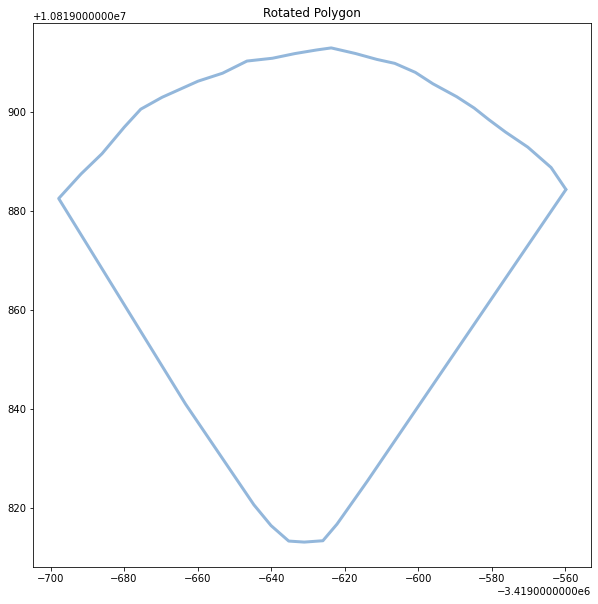

In [32]:
### Plot the rot_poly column
import matplotlib.pyplot as plt
import descartes

i = 210

shape = geom.shape(df['poly_rot'][i])
x, y = shape.exterior.xy

fig, ax = plt.subplots(figsize=(10,10))
ax.plot(x, y, color='#6699cc', alpha=0.7,
        linewidth=3, solid_capstyle='round', zorder=2)
ax.set_title('Rotated Polygon')
plt.show()



In [ ]:
########## Example of working plot using shapely

import shapely
from shapely.geometry import Polygon
from shapely.ops import unary_union
from shapely import affinity

############# TEST ###########
# i = 10
# angle = 45 - (df['foul_angle'][i])
# print(angle)


# total_poly = []
# angle = []

for i in range(len(df)):
    try:
    # COnvert the coordinates to a shapely polygon
        poly1 = Polygon(df['foul_poly'][i]['coordinates'][0])
        poly2 = Polygon(df['fop_poly'][i]['coordinates'][0])
        polygons = [poly1, poly2]
        total_poly = gpd.GeoSeries(unary_union(polygons))
        
        # Find the angle we need to rotate the polygon
        # angle = 45 - (df['foul_angle'][i])

        # # Rotate the polygon by the angle
        # total_poly = affinity.rotate(total_poly, angle, use_radians=False)

        # Plot the polygon
        total_poly.plot().show()
        # plt.show()
        


        
        
        
        # total_poly.plot()
    # plt.show()

        i+=1
    except:
        pass


# # # COnvert the coordinates to a shapely polygon
# # poly1 = Polygon(df['foul_poly'][i]['coordinates'][0])
# # poly2 = Polygon(df['fop_poly'][i]['coordinates'][0])


# # from shapely.ops import unary_union
# # polygons = [poly1, poly2]
# # boundry = gpd.GeoSeries(unary_union(polygons))
# # # boundary = df['total_poly'][i]
# # boundry.plot()
# # plt.show()



In [ ]:
df.info()

In [ ]:
########### MOVED ABOVE PLOT BLOCK ###################

# ############ TRANSFORM ###############


# # get home plate coords for each foul and fop
# ## this will be the first coordinate in the list of coordinates

# df['foul_hp'] = df['foul'].apply(lambda x: tuple(map(float, x.split(',')[0:2])))
# df['fop_hp'] = df['fop'].apply(lambda x: tuple(map(float, x.split(',')[0:2])))

# # FLIP THE COORDINATES
# df['foul_hp'] = df['foul_hp'].apply(lambda x: (x[1], x[0]))
# df['fop_hp'] = df['fop_hp'].apply(lambda x: (x[1], x[0]))

# ## Drop the extra zeros from the coordinates in the foul and fop columns
# df['foul'] = df['foul'].apply(lambda x: x.replace(',0', ','))
# df['fop'] = df['fop'].apply(lambda x: x.replace(',0', ','))

# ## get the second coordinate in the list of coordinates
# df['foul_2nd'] = df['foul'].apply(lambda x: tuple(map(float, x.split(',')[3:5])))
# df['fop_2nd'] = df['fop'].apply(lambda x: tuple(map(float, x.split(',')[3:5])))

# ## Create a line from home plate to the second coordinate
# df['foul_line'] = df.apply(lambda x: {'type': 'LineString', 'coordinates': [x['foul_hp'], x['foul_2nd']]}, axis=1)
# df['fop_line'] = df.apply(lambda x: {'type': 'LineString', 'coordinates': [x['fop_hp'], x['fop_2nd']]}, axis=1)



# ## Calulate the angle relative to horizontal of the foul and fop lines
# import math

# def angle(x1, y1, x2, y2):
#     dx = x2 - x1
#     dy = y2 - y1
#     rads = math.atan2(-dy,dx)
#     rads %= 2*math.pi
#     degs = math.degrees(rads)
#     return degs

# df['foul_angle'] = df.apply(lambda x: angle(x['foul_hp'][0], x['foul_hp'][1], x['foul_2nd'][0], x['foul_2nd'][1]), axis=1)
# df['fop_angle'] = df.apply(lambda x: angle(x['fop_hp'][0], x['fop_hp'][1], x['fop_2nd'][0], x['fop_2nd'][1]), axis=1)


# # Drop unnessisary columns
# df = df.drop(['foul_poly', 'fop', 'foul', 'fop_hp', 'foul_line', 'fop_line'], axis=1)

# df.head()

# df.head()


In [ ]:
# import math

# def angle(x1, y1, x2, y2):
#     dx = x2 - x1
#     dy = y2 - y1
#     rads = math.atan2(-dy,dx)
#     rads %= 2*math.pi
#     degs = math.degrees(rads)
#     return degs

# df['foul_angle'] = df.apply(lambda x: angle(x['foul_hp'][0], x['foul_hp'][1], x['foul_2nd'][0], x['foul_2nd'][1]), axis=1)
# df['fop_angle'] = df.apply(lambda x: angle(x['fop_hp'][0], x['fop_hp'][1], x['fop_2nd'][0], x['fop_2nd'][1]), axis=1)

# df.head()



In [ ]:
import shapely
from shapely.geometry import shape, Point, Polygon, LineString


## Goal orient all the polygons to the same angle

## Rotate each polygone to the same angle relative to horizontal

## Rotate each line to the same angle relative to horizontal
# i = 120

for i in range(0, len(df)):
    try:
        ### Rotate polygon
        geom = shape(df['boundry'][i])
        angle = 45 - (df['foul_angle'][i])


        # print(geom, angle)
        rot_plot = shapely.affinity.rotate(geom, angle, origin= Point(df[df['foul_hp']]), use_radians=False)
        

        ## add the rotated polygons to the dataframe
        df['boundry'][i] = shapely.geometry.mapping(rot_plot)
        

    

    ## pass on exceptions
    except:
        pass

df.head()
    




# Returns a rotated geometry on a 2D plane.  
# The angle of rotation can be specified in either degrees (default) or   radians by setting use_radians=True. Positive angles are counter-clockwise and   negative are clockwise rotations.  
# The point of origin can be a keyword ‘center’ for the bounding box center   (default), ‘centroid’ for the geometry’s centroid, a Point object or a   coordinate tuple (x0, y0).  
# The affine transformation matrix for 2D rotation is:  
# / cos(r) -sin(r) xoff | sin(r) cos(r) yoff | 0 0 1 /
# where the offsets are calculated from the origin Point(x0, y0)



In [ ]:
#### Make plots of the polygons

import matplotlib.pyplot as plt
# import descartes
# from descartes import PolygonPatch

i = 120

polygon = df['total_poly'][i]

plt.plot(*polygon.exterior.xy)



In [ ]:
from shapely.geometry import Polygon, Point, LineString
i = 210

plt.rcParams["figure.figsize"] = [7.00, 7.00]
plt.rcParams["figure.autolayout"] = True
polygon1 = df['total_poly'][i]['coordinates'][0]
# polygon2 = Polygon(df['fop_poly'][i]['coordinates'][0])

# x2, y2 = polygon2.exterior.xy
x, y = polygon1.exterior.xy


## Add text to plot

plt.text(x[0], y[0], df['field'][i], fontsize=12)

plt.plot(x, y, c="red")
# plt.plot(x2, y2, c="blue")
plt.show()#

In [ ]:
df.head()

i = 130

plt.rcParams["figure.figsize"] = [7.00, 7.00]
plt.rcParams["figure.autolayout"] = True
polygon1 = Polygon(df['foul_poly'][i]['coordinates'][0])
polygon2 = Polygon(df['fop_poly'][i]['coordinates'][0])

x2, y2 = polygon2.exterior.xy
x, y = polygon1.exterior.xy


## Add text to plot

plt.text(x[0], y[0], df['field'][i], fontsize=12)

plt.plot(x, y, c="red")
plt.plot(x2, y2, c="blue")
plt.show()